## Теор задание


### 1. PCA
Метод главных компонент направлен на снижение размерности данных путем нахождения такого направления в многомерном пространстве, вдоль которого дисперсия проекций объектов достигает максимума. Формально, для заданного набора точек в $ \mathbb{R}^n $ ищется прямая, максимизирующая разброс данных при проектировании на нее. Этот разброс количественно выражается через дисперсию.


### 2. Роль ковариационной матрицы
Ковариационная матрица $ \Sigma $ описывает структуру вариации данных во всех возможных направлениях. Для произвольного единичного вектора $ \mathbf{w} $ (т.е. $ \|\mathbf{w}\| = 1 $), задающего направление, дисперсия проекций точек на это направление определяется выражением:
$$
D = \mathbf{w}^{\top} \Sigma \mathbf{w}.
$$
Таким образом, задача PCA сводится к поиску $ \mathbf{w} $, максимизирующего данную квадратичную форму при указанном ограничении на норму.


### 3. Собственные векторы и собственные значения
Ковариационная матрица $ \Sigma $ является симметричной и положительно полуопределенной, что гарантирует существование ортонормированного базиса из собственных векторов. Для каждого собственного вектора $ \mathbf{v}_k $ выполняется:
$$
\Sigma \mathbf{v}_k = \lambda_k \mathbf{v}_k,
$$
где $ \lambda_k $ — соответствующее собственное значение, характеризующее масштаб преобразования вдоль направления $ \mathbf{v}_k $. Собственные значения $ \lambda_k $ упорядочиваются по убыванию: $ \lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_n $.


### 4. Первая главная компонента
Первая главная компонента определяется направлением, максимизирующим дисперсию. Рассмотрим задачу оптимизации:
$$
\max_{\mathbf{w}} \mathbf{w}^{\top} \Sigma \mathbf{w}, \quad \text{при} \quad \|\mathbf{w}\| = 1.
$$
Любой единичный вектор $ \mathbf{w} $ можно представить в виде линейной комбинации собственных векторов $ \mathbf{v}_k $:
$$
\mathbf{w} = \sum_{k} a_k \mathbf{v}_k, \quad \text{где} \quad \sum_{k} a_k^2 = 1.
$$
Подставляя это в выражение для дисперсии и учитывая ортогональность собственных векторов, получаем:
$$
\mathbf{w}^{\top} \Sigma \mathbf{w} = \left( \sum_{k} a_k \mathbf{v}_k \right)^{\top} \Sigma \left( \sum_{j} a_j \mathbf{v}_j \right) = \sum_{k} a_k^2 \lambda_k.
$$
Так как $ \sum_{k} a_k^2 = 1 $, значение $ \sum_{k} a_k^2 \lambda_k $ достигает максимума, равного $ \lambda_1 $ (наибольшему собственному значению), когда $ a_1 = 1 $, а все остальные $ a_k = 0 $ (для $ k \neq 1 $). Следовательно, $ \mathbf{w} = \mathbf{v}_1 $, где $ \mathbf{v}_1 $ — собственный вектор, соответствующий $ \lambda_1 $.


### 5. Последующие главные компоненты
Вторая главная компонента ищется в подпространстве, ортогональном к $ \mathbf{v}_1 $, путем решения аналогичной задачи максимизации дисперсии в этом подпространстве. Решением оказывается собственный вектор $ \mathbf{v}_2 $, соответствующий второму по величине собственному значению $ \lambda_2 $. Процесс продолжается рекурсивно: каждая последующая компонента $ \mathbf{v}_k $ ортогональна предыдущим и соответствует $ \lambda_k $, где $ k $ увеличивается по мере убывания $ \lambda_k $.

## Dummy

In [1]:
import math
import random
import nampy as np


### Гаусс

In [2]:
def gauss_solver(A: np.array, b: np.array) -> np.array:
    rows, cols = A.shape
    if rows != b.shape[0]:
        raise ValueError(f"Размерности не совпадают: A({A.shape}), b({b.shape})")

    Ab = np.hstack([A, b])

    pivot_row = 0
    pivot_cols = []

    # Приведение к ступенчатому виду
    for j in range(cols):
        if pivot_row >= rows:
            break

        # Поиск максимального элемента в столбце j ниже pivot_row
        max_row = pivot_row
        for i in range(pivot_row + 1, rows):
            if abs(Ab[i, j]) > abs(Ab[max_row, j]):
                max_row = i
        Ab.swap(pivot_row, max_row)

        pivot_val = Ab[pivot_row, j]
        if abs(pivot_val) < np.EPS:
            continue

        pivot_cols.append(j)

        Ab.div(pivot_row, pivot_val)

        # Обнуление элементов под ведущим элементом
        for i in range(rows):
            if i != pivot_row:
                factor = Ab[i, j]
                Ab.comb_rows(i, pivot_row, -factor)

        pivot_row += 1

    # Проверка на несовместность
    for i in range(pivot_row, rows):
        if abs(Ab[i, cols]) > np.EPS:
            raise ValueError("Система несовместна")

    rank = len(pivot_cols)

    # Единственное решение
    if rank == cols:
        solution = np.zeros((cols, 1))
        for i in range(rank - 1, -1, -1):
            pivot_col_idx = pivot_cols[i]
            val = Ab[i, cols]
            for k in range(pivot_col_idx + 1, cols):
                val -= Ab[i, k] * solution[k, 0]
            solution[pivot_col_idx, 0] = val
        return [np.array(solution.T)]

    # Бесконечно много решений
    elif rank < cols:
        # print(f"WARNING: для матрицы \n{A}\nвозвращается ФСР")
        free_vars_indices = [j for j in range(cols) if j not in pivot_cols]

        fsr_basis = []
        for _, free_idx in enumerate(free_vars_indices):
            basis_vector = np.zeros((cols, 1))

            # Устанавливаем текущую свободную переменную в 1, остальные свободные остаются 0
            basis_vector[free_idx, 0] = 1

            for j in range(rank - 1, -1, -1):
                pivot_col_idx = pivot_cols[j]
                val = 0
                for k in range(pivot_col_idx + 1, cols):
                    val -= Ab[j, k] * basis_vector[k, 0]
                basis_vector[pivot_col_idx, 0] = val

            fsr_basis.append(basis_vector.T)

        return fsr_basis

In [3]:
A = np.array([[2, 1, 1], [1, -1, 0], [3, -1, 2]])
b = np.array([2, -2, 2]).T
print("Case 1:")
sol = gauss_solver(A, b)
print(sol)

A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
b = np.array([[1], [2], [3]])
print("\nCase 2:")
sol = gauss_solver(A, b)
print(sol)


A = np.array([[2, 1, -1], [-3, -1, 2], [-2, 1, 2]])
b = np.array([[8], [-11], [-3]])
print("\nCase 3:")
sol = gauss_solver(A, b)
print(sol)


A = np.array([[1, 1], [1, 1]])
b = np.array([[1], [2]])
print("\nCase 4:")
try:
    sols = gauss_solver(A, b)
    print(sols)
except ValueError as e:
    print(e)

A = np.array([[1, 1, 1], [2, 2, 2]])
b = np.array([3, 6]).T
print("\nCase 5:")
sol = gauss_solver(A, b)
print(sol)

Case 1:
[[ -1.0000   1.0000   3.0000]]

Case 2:
[[  1.0000  -2.0000   1.0000]]

Case 3:
[[  2.0000   3.0000  -1.0000]]

Case 4:
Система несовместна

Case 5:
[[ -1.0000   1.0000   0.0000], [ -1.0000   0.0000   1.0000]]


### Ну и так нормально получилось

In [4]:
def center_data(X: np.array) -> np.array:
    """
    Вход: матрица данных X (n*m)
    Выход: центрированная матрица X_centered (n*m)
    """
    mean = np.array([[np.mean(X[:, i]) for i in range(X.shape[1])]] * X.shape[0])
    return X - mean


q = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [1, 4, 5]])
print(center_data(q))

[ -2.2500  -2.7500  -2.7500]
[  0.7500   0.2500   0.2500]
[  3.7500   3.2500   3.2500]
[ -2.2500  -0.7500  -0.7500]


In [5]:
def covariance_matrix(X: np.array) -> np.array:
    """
    Вход: центрированная матрица X (n*m)
    Выход: матрица ковариаций C (m*m)
    """
    return (1 / (X.shape[0] - 1)) * (X.T @ X)


С = covariance_matrix(center_data(q))
С

[  8.2500   6.7500   6.7500]
[  6.7500   6.2500   6.2500]
[  6.7500   6.2500   6.2500]

### Eigen


In [6]:
def gershgorin_interval(C: np.array, eps: float = np.EPS) -> [float, float]:
    rows, cols = C.shape

    min_bound = np.INF
    max_bound = np.NINF

    for i in range(rows):
        diagonal_element = C[i, i]
        radius = 0
        for j in range(cols):
            if i != j:
                radius += abs(C[i, j])

        lower_i = diagonal_element - radius
        upper_i = diagonal_element + radius

        if lower_i < min_bound:
            min_bound = lower_i
        if upper_i > max_bound:
            max_bound = upper_i

    return min_bound - eps, max_bound + eps


def direct_det_func(C: np.array, x: float) -> float:
    """
    Вычисляет значение характеристического полинома det(C - xI)
    """

    C_xI = C - np.eye(C.shape[0]) * x
    return C_xI.det


def find_all_roots(func, a, b, step: float = 0.01, tol: float = np.EPS) -> [float]:
    """
    Находит все корни функции func на интервале [a, b] методом деления отрезка пополам
    """
    roots = []
    x1 = a
    f1 = func(x1)

    if abs(f1) < tol:
        roots.append(x1)

    while x1 < b:
        x2 = min(x1 + step, b)
        f2 = func(x2)

        if abs(f2) < tol and abs(x2 - b) > tol:
            roots.append(x2)

        # Проверяем смену знака
        if f1 * f2 < 0:
            low = x1
            high = x2
            val_low = f1

            # Итерации бисекции
            while (high - low) / 2.0 > tol:
                mid = (low + high) / 2.0
                val_mid = func(mid)

                if abs(val_mid) < tol:
                    low = mid
                    high = mid
                    break

                if val_low * val_mid < 0:
                    high = mid
                else:
                    low = mid
                    val_low = val_mid

            found_root = (low + high) / 2.0

            is_duplicate = False
            for root in roots:
                if abs(root - found_root) < tol:
                    is_duplicate = True
                    break

            if not is_duplicate:
                roots.append(found_root)

        # Проверка на кратные корни
        elif abs(f1) < tol * 10 or abs(f2) < tol * 10:
            num_checks = 10
            sub_step = (x2 - x1) / num_checks
            for i in range(1, num_checks):
                x_check = x1 + i * sub_step
                f_check = func(x_check)
                if abs(f_check) < tol:
                    is_duplicate = False
                    for root in roots:
                        if abs(root - x_check) < tol:
                            is_duplicate = True
                            break
                    if not is_duplicate:
                        roots.append(x_check)

        x1 = x2
        f1 = f2

    # Проверяем, является ли конечная точка интервала корнем
    if abs(func(b)) < tol:
        is_duplicate = False
        for root in roots:
            if abs(root - b) < tol:
                is_duplicate = True
                break
        if not is_duplicate:
            roots.append(b)

    # Сортируем корни
    roots.sort(reverse=True)
    return roots

In [7]:
def find_eigenvalues(C: np.array, tol: float = np.EPS) -> [float]:
    a, b = gershgorin_interval(C)
    print(a, b)

    def characteristic_polynomial(x: float) -> float:
        return direct_det_func(C, x)

    roots = find_all_roots(
        characteristic_polynomial, a, b, step=(b - a) / 10000, tol=tol
    )
    return roots


# C = np.array([[5, 6, 3], [-1, 0, 1], [1, 2, -1]])
# C = np.array([[4,1], [1,2]])
C = np.array([[-1, -6], [2, 6]])
# C = np.array([[5, -1, -1], [0, 4, -1], [0, -1, 4]])
eigenvalues = np.clip(np.array(find_eigenvalues(C)))
print(eigenvalues)

-7.0000000001 8.0000000001
[  3.0000   2.0000]


In [8]:
def find_eigenvectors(C: np.array, eigenvalues: [float]) -> [np.array]:
    eigenvectors = []
    n = C.shape[0]
    I = np.eye(n)
    for lambada in eigenvalues:
        A = C - (lambada * I)

        x = gauss_solver(A, np.zeros((n, 1)))

        eigenvectors.append(x)
    return eigenvectors


eigenvectors = find_eigenvectors(C, eigenvalues)
for eig in eigenvectors:
    print(eig)

[[ -1.5000   1.0000]]
[[ -2.0000   1.0000]]


In [9]:
def explained_variance_ratio(eigenvalues: [float], k: int) -> float:
    if not eigenvalues:
        raise ValueError("Eigenvalues array cannot be empty")
    if k <= 0:
        raise ValueError("k must be positive")
    if k > len(eigenvalues):
        raise ValueError("k cannot be greater than number of eigenvalues")
    if sum(eigenvalues) == 0:
        raise ValueError("Sum of eigenvalues cannot be zero")

    eigenvalues.sort(reverse=True)
    return sum(eigenvalues[:k]) / sum(eigenvalues)

### Expert

In [10]:
def auto_select_k(eigenvalues: [float], threshold: float = 0.95) -> int:
    m = len(eigenvalues)
    eigenvalues.sort(reverse=True)
    if m == 0:
        raise ValueError("Eigenvalues array cannot be empty")

    total = sum(eigenvalues)
    if abs(total) < np.EPS:
        raise ValueError("Сумма собственных значений близка к 0, нельзя разделить")

    cumulative = 0.0
    for i, val in enumerate(eigenvalues, start=1):
        cumulative += val
        ratio = cumulative / total
        if ratio >= threshold:
            return i

    return m

In [11]:
def handle_missing_values(X: np.array) -> np.array:
    raw_X = X.copy()
    nan_idxs = []

    for i in range(raw_X.shape[0]):
        for j in range(raw_X.shape[1]):
            if math.isnan(raw_X[i, j]):
                nan_idxs.append((i, j))
                raw_X[i, j] = 0

    if nan_idxs == []:
        return X
    else:
        for i, j in nan_idxs:
            raw_X[i, j] = np.mean(raw_X[:, j])
        return raw_X

In [12]:
n = 5
X_stupid = center_data(np.utils.random_matrix((n, n)))
C = covariance_matrix(X_stupid)
eigenvalues = find_eigenvalues(C, tol=np.EPS)
print(eigenvalues)
eigenvectors = find_eigenvectors(C, eigenvalues)
print(eigenvectors)

-0.14954606124539338 0.3198053105164657
[0.2931566946722114, 0.07795148209364983, 0.07794854864757632, 0.04183196059050193, 0.002289107519565657, 0.002265639950977564, 0.002242172382389471, 0.0022374788686718525, 0.0022327853549542337, 0.0022280918412366153, 0.0022233983275189964, 0.002218704813801378, 0.0022140113000837596, 0.0022093177863661407, 0.0022046242726485223, 0.0021999307589309035, 0.002195237245213285, 4.560796254397074e-05, 4.091444882635215e-05, 3.622093510873356e-05, 1.2753366520640604e-05, -1.071420206745235e-05, -1.540771578507094e-05, -2.0101229502689534e-05, -2.4794743220308126e-05, -2.9488256937926714e-05, -3.41817706555453e-05, -3.8875284373163895e-05, -4.356879809078249e-05]
[[[  0.0000   0.0000   0.0000  -0.0000   0.0000]], [[  0.0000   0.0000   0.0000   0.0000  -0.0000]], [[  0.0000   0.0000   0.0000  -0.0000   0.0000]], [[  0.0000   0.0000   0.0000  -0.0000   0.0000]], [[  0.0000   0.0000   0.0000   0.0000  -0.0000]], [[  0.0000   0.0000   0.0000   0.0000  -0.0

## nampy.linalg


In [13]:
import matplotlib.pyplot as plt
import nampy.linalg as linalg

X_rnd = np.utils.random_matrix((1000, 20))

In [14]:
def pca(X: np.array, threshold: float = 0.95) -> [np.array, float]:
    X = np.std_scale(X, axis=0)
    X = center_data(X)
    C = covariance_matrix(X)
    eigenvalues, eigenvectors = linalg.qr_eigen_decomposition(C)
    # print(eigenvalues)
    # print(eigenvectors)

    k = auto_select_k(eigenvalues, threshold)

    W = eigenvectors[:, :k]
    return X @ W, explained_variance_ratio(eigenvalues, k)


pca_rnd, c = pca(X_rnd, threshold=0.9)
print(pca_rnd[:5, :])
print(c)

[ -0.0628  -0.4922  -0.9285  -0.8768  -0.1499  -0.1613  -1.1128   1.0012   2.5264  -0.0387   2.3312   0.4823  -0.7262   0.6695  -0.7281   0.1042  -0.1782  -0.2204]
[ -2.3145   0.4368  -0.2300   1.1964  -0.4926  -1.4304  -0.7044   0.0292   0.5308   1.3416  -1.6244  -0.2921  -1.4058   1.6353   0.9664   0.1743   1.0057  -0.7175]
[  1.7769  -1.2457  -0.9528  -0.9810  -0.0928   0.5136   0.3193   0.0870  -0.0485   1.0279  -0.6923   0.5249  -0.0862  -1.4290  -1.2617   1.0586  -1.0550   1.0508]
[  0.7305   0.8425   1.3722  -0.7554  -1.6115   0.9850   0.9028   2.1104  -1.9431  -0.7029   1.6057  -0.5007  -0.4026   1.2231  -1.1164   0.0005  -1.7663  -0.5263]
[ -0.0444  -0.8240  -1.5349  -1.1705   1.5992   1.3883  -1.0162   0.0594   1.1311  -0.0398   0.9999   2.0524  -0.2862   0.7360   1.7205   0.3185  -1.0181  -0.8386]
0.9185054826830282


In [15]:
def reconstruction_error(X_orig: np.array, X_recon: np.array) -> float:
    assert X_orig.shape == X_recon.shape, (
        f"Shapes must match. Got {X_orig.shape} and {X_recon.shape}"
    )
    n, m = X_orig.shape
    diff = X_orig - X_recon
    mse = np.sum(diff * diff) / (n * m)
    return mse


reconstruction_error(pca_rnd, pca_rnd + 1)

1.0

In [16]:
def add_noise(X: np.array, alpha: float = 0.1) -> np.array:
    std_dev = X.std

    noise = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # Генерируем случайный шум с нормальным распределением
            # используя алгоритм Бокса-Мюллера
            u1 = random.random()
            u2 = random.random()
            z = (-2 * math.log(u1)) ** 0.5 * math.cos(2 * math.pi * u2)

            # Масштабируем шум уровнем шума и стандартным отклонением
            noise[i, j] = z * alpha * std_dev

    # Добавляем шум к исходным данным
    X_noisy = X + noise

    return X_noisy


X_rnd_n = add_noise(X_rnd, alpha=1)
reconstruction_error(X_rnd, X_rnd_n)

0.0846279699574903

Alpha: 1.00, Error: 2.1961
Alpha: 3.16, Error: 2.0280
Alpha: 10.00, Error: 2.0053
Alpha: 31.62, Error: 2.0356
Alpha: 100.00, Error: 1.9941


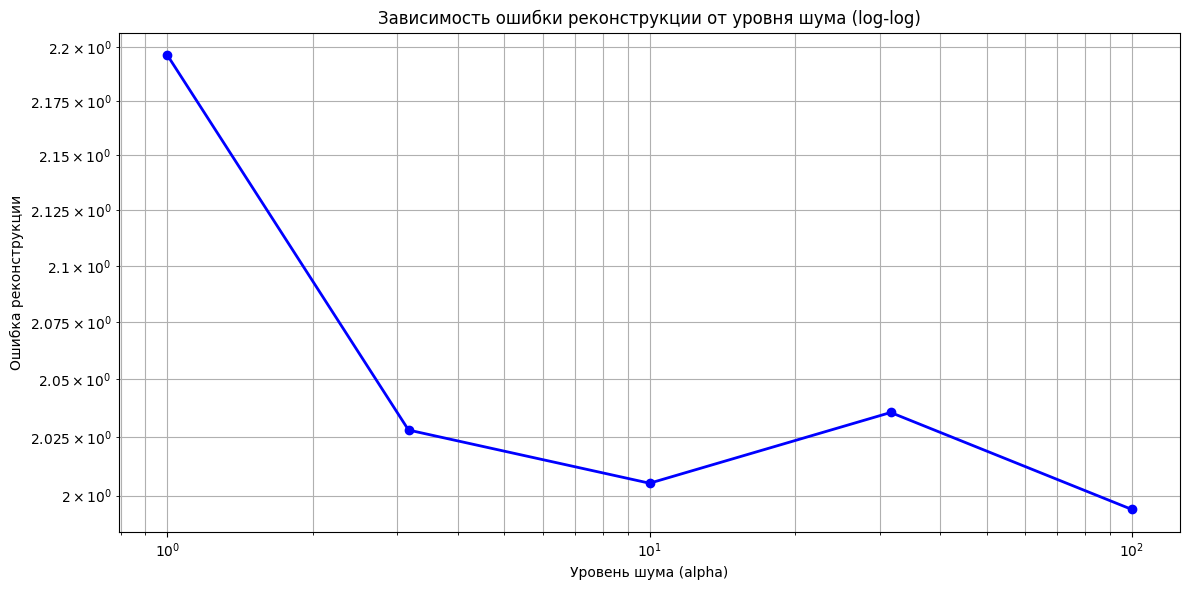

In [17]:
def compare_reconstruction_errors(X, alphas):
    """
    На самом деле бессмыслицы потому что тупо меняем исходные данные
    """
    errors = []

    for alpha in alphas:
        X_pca, _ = pca(X)

        X_noisy = add_noise(X, alpha=alpha)
        X_pca_noisy, _ = pca(X_noisy)

        error = reconstruction_error(X_pca, X_pca_noisy)
        errors.append(error)

        print(f"Alpha: {alpha:.2f}, Error: {error:.4f}")

    # Визуализируем результаты в логарифмическом масштабе
    plt.figure(figsize=(12, 6))

    plt.loglog(alphas, errors, "o-", linewidth=2, markersize=6, color="blue")

    plt.xlabel("Уровень шума (alpha)")
    plt.ylabel("Ошибка реконструкции")
    plt.title("Зависимость ошибки реконструкции от уровня шума (log-log)")
    plt.grid(True, which="both", ls="-")
    plt.tight_layout()
    plt.show()

    return errors


alphas = np.log_range(0, 100, 5)
_ = compare_reconstruction_errors(X_rnd, alphas)

## REAL DATA

In [18]:
X, y = np.read_csv("./test_data/housing.csv", target_col=-2)
print("SHAPE:", X.shape)
print(X[:10, :])

SHAPE: (20640, 9)
[-122.2300  37.8800  41.0000 880.0000 129.0000 322.0000 126.0000   8.3252   0.0000]
[-122.2200  37.8600  21.0000 7099.0000 1106.0000 2401.0000 1138.0000   8.3014   0.0000]
[-122.2400  37.8500  52.0000 1467.0000 190.0000 496.0000 177.0000   7.2574   0.0000]
[-122.2500  37.8500  52.0000 1274.0000 235.0000 558.0000 219.0000   5.6431   0.0000]
[-122.2500  37.8500  52.0000 1627.0000 280.0000 565.0000 259.0000   3.8462   0.0000]
[-122.2500  37.8500  52.0000 919.0000 213.0000 413.0000 193.0000   4.0368   0.0000]
[-122.2500  37.8400  52.0000 2535.0000 489.0000 1094.0000 514.0000   3.6591   0.0000]
[-122.2500  37.8400  52.0000 3104.0000 687.0000 1157.0000 647.0000   3.1200   0.0000]
[-122.2600  37.8400  42.0000 2555.0000 665.0000 1206.0000 595.0000   2.0804   0.0000]
[-122.2500  37.8400  52.0000 3549.0000 707.0000 1551.0000 714.0000   3.6912   0.0000]


In [19]:
from model import train_test_split, LinearRegression


def test_pca(X: np.array, y: np.array, threshold: float = 0.95) -> [np.array, float]:
    X, _ = pca(X, threshold=threshold)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_seed=42
    )

    linreg = LinearRegression().fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.metrics.rmse(y_test, y_pred)


test_pca(X, y, threshold=0.9)

78991.22745603028

In [20]:
import plotly.graph_objects as go
from numpy import argmin


def analyze_test_pca(matrices, names=None):
    if names is None:
        names = [f"Матрица {i + 1}" for i in range(len(matrices))]

    thresholds = np.log_range(1, 0.8, 10)
    optimal_results = []
    fig = go.Figure()

    for i, ((X, y), name) in enumerate(zip(matrices, names)):
        print(name, end="\r")
        rmse_values = [test_pca(X, y, t) for t in thresholds]
        base_rmse = rmse_values[0]
        rmse_percent = [(rmse - base_rmse) / base_rmse * 100 for rmse in rmse_values]

        fig.add_trace(
            go.Scatter(
                x=thresholds,
                y=rmse_percent,
                mode="lines+markers",
                name=name,
                hovertemplate=(
                    f"<b>{name}</b><br>"
                    + "Порог: %{x:.3f}<br>"
                    + "Изменение RMSE: %{y:.2f}%<extra></extra>"
                ),
            )
        )

        optimal_idx = argmin(rmse_values)
        optimal_results.append(
            {
                "name": name,
                "threshold": thresholds[optimal_idx],
                "rmse": rmse_values[optimal_idx],
                "base_rmse": base_rmse,
                "improvement": base_rmse - rmse_values[optimal_idx],
                "improvement_percent": (base_rmse - rmse_values[optimal_idx])
                / base_rmse
                * 100,
            }
        )

    fig.add_shape(
        type="line",
        x0=thresholds[0],
        x1=thresholds[-1],
        y0=0,
        y1=0,
        line=dict(color="red", dash="dash"),
        opacity=0.7,
    )

    fig.update_layout(
        title="Процентное изменение RMSE относительно порога 1.0",
        xaxis_title="Порог объясненной дисперсии",
        yaxis_title="Процентное изменение RMSE (%)",
        xaxis=dict(autorange="reversed"),  # инвертируем ось X
        template="plotly_white",
        legend=dict(title="Матрицы"),
        height=600,
    )

    fig.show()
    return optimal_results

In [21]:
dataset_paths = [
    ("./test_data/housing.csv", -2),
    ("./test_data/salary.csv", -1),
    ("./test_data/Concrete_Data.csv", -1),
    ("./test_data/insurance.csv", -1),
]

real_matrices = []
for dataset_path, target_col in dataset_paths:
    X, y = np.read_csv(dataset_path, target_col)
    real_matrices.append((X, y))

real_names = ["Housing", "Salary", "Concrete", "Insurance"]

optimal_results_real = analyze_test_pca(real_matrices, real_names)

In [22]:
synthetic_matrices = []
synthetic_names = []

for n_features in [5, 10, 15, 20]:
    X, y = np.random_matrix((1000, n_features)), np.random_matrix((1000, 1))

    synthetic_matrices.append((X, y))
    synthetic_names.append(f"Synthetic (n={n_features})")

optimal_results_synthetic = analyze_test_pca(synthetic_matrices, synthetic_names)